**You will find here all the results related to the first approach in the local volatility model.**

In [1]:
import numpy as np
import pandas as pd
# We import from assets all the parameters for the local volatility model
from assets import N_Local, S0, Neuler_Local, T, K, L_Local, r, G, weight_Local

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

from model import DNN
from numpy.linalg import matrix_rank, inv
from scipy.linalg import null_space
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from assets import f_Call_Basket, f_Put_Worst_Of, f_Digit_Basket, f_Asian_Arithmetic

In [2]:
summary = {'Number of assets' : N_Local, '(Neuler, T)' : (Neuler_Local, T), '(K, S0)' : (K, S0)}
summary

{'Number of assets': 10, '(Neuler, T)': (100, 1), '(K, S0)': (100, 100)}

In [3]:
nb_samples = int(1e5)
M_simulation = int(1e4)
sns.set(style="darkgrid")

In [4]:
def simulation(W, f, N):
    Z_simul = np.random.randn(M_simulation, N)
    y = f(Z_simul)

    U = W/ np.sqrt(np.sum(W * W, axis = 1)).reshape(-1,1)
    V = null_space(U).T
    M = np.concatenate((U,V), axis = 0)
    
    Z_simul = np.random.randn(M_simulation, N)
    Z_tilde = U@Z_simul.T
    n = Z_tilde.shape[0]
    tmp = np.concatenate((Z_tilde, np.zeros((N-n, M_simulation))))
    control_variate = f((inv(M)@tmp).T)
    control_variate_mean = np.mean(control_variate)
    Y_control = f(Z_simul) - control_variate + control_variate_mean
    return y, Y_control


def simulation_robust(W, f, N):
    Z_simul = np.random.randn(M_simulation, N)
    y = f(Z_simul)

    U = W/ np.sqrt(np.sum(W * W, axis = 1)).reshape(-1,1)
    V = null_space(U).T
    M = np.concatenate((U,V), axis = 0)
    
    Z_simul = np.random.randn(M_simulation, N)
    Z_tilde = U@Z_simul.T
    Z_tilde_ortho = V@Z_simul.T
    tmp = np.concatenate((Z_tilde, Z_tilde_ortho))
    control_variate = f((inv(M)@tmp).T)
    return np.mean(y), np.mean(control_variate)

In [5]:
def plot_simulation(y, Y_control, bins = [100,100, 100,100]):
    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    plt.hist(y, bins = bins[0], label = 'mean = %.3f\nvar = %.5f'%(y.mean(), y.var()))
    plt.title('distribution of the initial_variable')
    plt.legend()
    plt.subplot(1,3,2)
    plt.hist(Y_control, bins = bins[1], label = 'mean = %.3f\nvar = %.5f'%(Y_control.mean(), Y_control.var()), color='orange')
    plt.title('distribution using control variate')
    plt.legend()
    plt.subplot(1,3,3)
    plt.hist(y, bins = bins[2], label = 'initial variable')
    plt.hist(Y_control,bins = bins[3], label = "control variate ", color='orange')
    plt.title('comparaison of distribution')
    plt.legend()
    plt.show()

# Basket Call Option

### 1. Data generation

In [ ]:
Z = np.random.randn(nb_samples, N_Local * Neuler_Local)
f_Basket_Local = lambda x: f_Call_Basket(x, K=K, L=L_Local, model='Local', Neuler=Neuler_Local, r=r, S0=S0, T=T, weight=weight_Local, is_Euler=True)
y = f_Basket_Local(Z)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

### 2. Model Creation

In [ ]:
nnmodel_basket_Local = DNN(N_Local * Neuler_Local, n=3)

In [ ]:
nnmodel_basket_Local.fit(X_train, y_train, eval_set=(X_test,y_test), verbose = True, patience = 25)

# Save the model
filename = 'Basket_Local.sav'
pickle.dump(nnmodel_basket_Local, open(filename, 'wb'))

Epoch 1/1000
2500/2500 [==============================] - 5s 2ms/step - loss: 5.2251 - mse: 5.2251 - val_loss: 1.0850 - val_mse: 1.0850
Epoch 2/1000
2500/2500 [==============================] - 5s 2ms/step - loss: 0.8303 - mse: 0.8303 - val_loss: 0.4180 - val_mse: 0.4180
Epoch 3/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 0.5571 - mse: 0.5571 - val_loss: 0.4557 - val_mse: 0.4557
Epoch 4/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4587 - mse: 0.4587 - val_loss: 0.2646 - val_mse: 0.2646
Epoch 5/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 0.3651 - mse: 0.3651 - val_loss: 0.3514 - val_mse: 0.3514
Epoch 6/1000
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3698 - mse: 0.3698 - val_loss: 0.3845 - val_mse: 0.3845
Epoch 7/1000
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3227 - mse: 0.3227 - val_loss: 0.1636 - val_mse: 0.1636
Epoch 8/1000
2500/2500 [========================

### 3. Test  and evaluation of the model
We evaluate our model using Mean Square Error:  
    - first we generate a test set sample  
    - then we predict and evaluate the model

In [ ]:
Z = np.random.randn(M_simulation, N_Local * Neuler_Local)
y = f_Basket_Local(Z)
y_pred = nnmodel_basket_Local.model.predict(Z)
print('Monte Carlo price = {:.4}. Control variate price = {:.4}'.format(np.mean(y), np.mean(y_pred)))
mean_squared_error(y, y_pred)

313/313 [==============================] - 1s 893us/step
Monte Carlo price = 6.249. Control variate price = 6.329


0.09002027275948872

### 4. Simulation

In [ ]:
W = nnmodel_basket_Local.model.get_weights()[0].T
print(matrix_rank(W)==len(W)) # we check that our matrix has maximal rank
y, Y_control = simulation(W, f_Basket_Local, N_Local * Neuler_Local)
MC, CV = simulation_robust(W, f_Basket_Local, N_Local * Neuler_Local)
print(MC, CV)

True
6.023190164222874 6.025870128532375


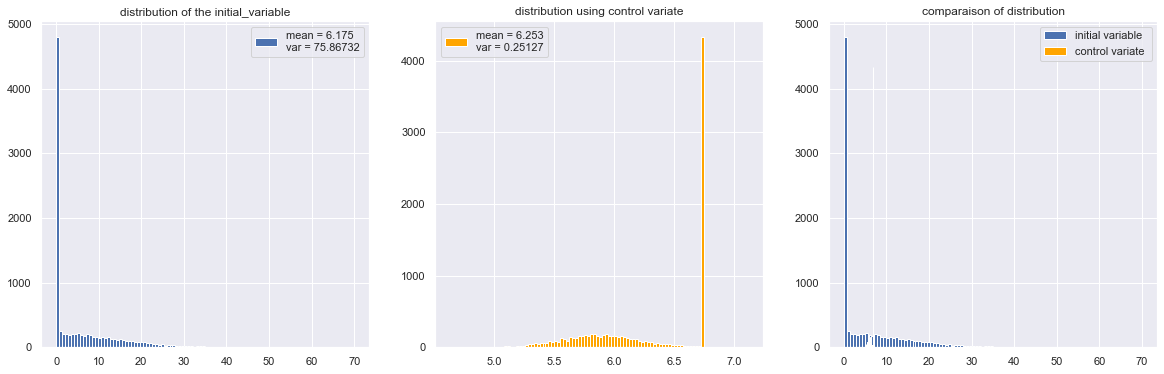

In [ ]:
plot_simulation(y, Y_control, ['auto', 'auto', 'auto', 10])

# Put  Worst-Of  Option

### 1. Data generation

In [ ]:
Z = np.random.randn(nb_samples, N_Local * Neuler_Local)
f_PWO_Local = lambda x: f_Put_Worst_Of(x, K=K, L=L_Local, model='Local', Neuler=Neuler_Local, r=r, S0=S0, T=T, is_Euler=True)
y = f_PWO_Local(Z)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

### 2. Model Creation

In [ ]:
nnmodel_PWO_Local = DNN(N_Local * Neuler_Local, n=3)

In [ ]:
nnmodel_PWO_Local.fit(X_train, y_train, eval_set=(X_test,y_test), verbose = True, patience=30)

# Save the model
filename = 'PWO_Local.sav'
pickle.dump(nnmodel_PWO_Local, open(filename, 'wb'))

Epoch 1/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 43.5767 - mse: 43.5767 - val_loss: 32.2715 - val_mse: 32.2715
Epoch 2/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 30.0905 - mse: 30.0905 - val_loss: 29.1541 - val_mse: 29.1541
Epoch 3/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 27.5588 - mse: 27.5588 - val_loss: 27.5092 - val_mse: 27.5092
Epoch 4/1000
2500/2500 [==============================] - 3s 1000us/step - loss: 26.5610 - mse: 26.5610 - val_loss: 26.7377 - val_mse: 26.7377
Epoch 5/1000
2500/2500 [==============================] - 2s 931us/step - loss: 25.8019 - mse: 25.8019 - val_loss: 26.1356 - val_mse: 26.1356
Epoch 6/1000
2500/2500 [==============================] - 4s 2ms/step - loss: 25.1969 - mse: 25.1969 - val_loss: 25.8698 - val_mse: 25.8698
Epoch 7/1000
2500/2500 [==============================] - 4s 2ms/step - loss: 24.8745 - mse: 24.8745 - val_loss: 25.8063 - val_mse: 25.8063
Epoch 8/1000
25

### 3. Test  and evaluation of the model

In [ ]:
Z = np.random.randn(M_simulation, N_Local * Neuler_Local)
y = f_PWO_Local(Z)
y_pred = nnmodel_PWO_Local.model.predict(Z)
print('Monte Carlo price = {:.4}. Control variate price = {:.4}'.format(np.mean(y), np.mean(y_pred)))
mean_squared_error(y, y_pred)

313/313 [==============================] - 0s 579us/step
Monte Carlo price = 13.19. Control variate price = 13.3


24.487363651573823

### 4. Simulation

In [ ]:
W = nnmodel_PWO_Local.model.get_weights()[0].T
print(matrix_rank(W)==len(W)) # we check that our matrix has maximal rank
y, Y_control = simulation(W, f_PWO_Local, N_Local * Neuler_Local)
MC, CV = simulation_robust(W, f_PWO_Local, N_Local * Neuler_Local)
print(MC, CV)

True
13.28556909260478 13.144362070786796


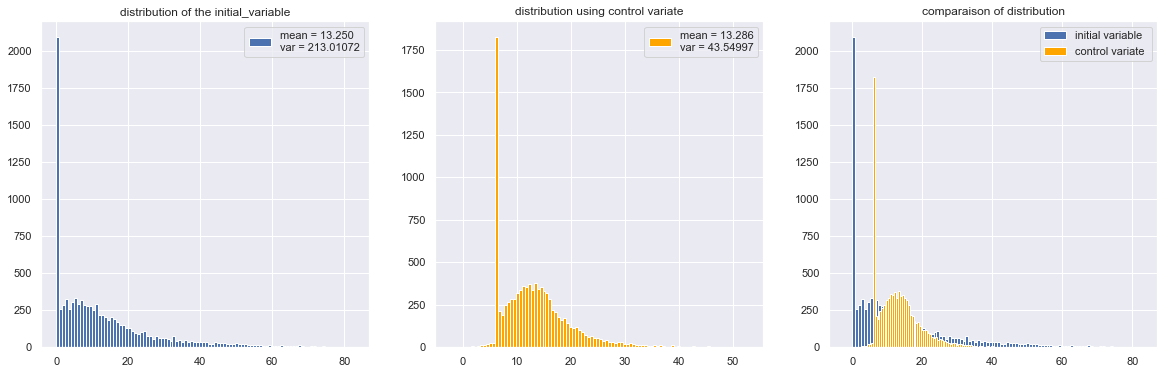

In [ ]:
plot_simulation(y, Y_control)

# Binary option (a digit) on the basket

### 1. Data generation

In [ ]:
Z = np.random.randn(nb_samples, N_Local * Neuler_Local)
f_Digit_Local = lambda x: f_Digit_Basket(x, G=G, K=K, L=L_Local, model='Local', Neuler=Neuler_Local, r=r, S0=S0, T=T, weight=weight_Local, is_Euler=True)
y = f_Digit_Local(Z)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)
y_train = (y_train == 0).reshape(-1,1)
y_test = (y_test == 0).reshape(-1,1)

### 2. Model Creation
for this task we are using a binary classifier

In [ ]:
nnmodel_Digit_Local = DNN(N_Local * Neuler_Local, n=3, prediction_type="bin_class")

In [ ]:
nnmodel_Digit_Local.fit(X_train, y_train, eval_set=(X_test,y_test), verbose = True, patience=30)

# Save the model
filename = 'Digit_Local.sav'
pickle.dump(nnmodel_Digit_Local, open(filename, 'wb'))

Epoch 1/1000
2500/2500 [==============================] - 4s 1ms/step - loss: 0.1908 - binary_accuracy: 0.9125 - val_loss: 0.1349 - val_binary_accuracy: 0.9395
Epoch 2/1000
2500/2500 [==============================] - 2s 986us/step - loss: 0.1205 - binary_accuracy: 0.9467 - val_loss: 0.1099 - val_binary_accuracy: 0.9505
Epoch 3/1000
2500/2500 [==============================] - 2s 991us/step - loss: 0.1062 - binary_accuracy: 0.9534 - val_loss: 0.1109 - val_binary_accuracy: 0.9520
Epoch 4/1000
2500/2500 [==============================] - 2s 965us/step - loss: 0.0993 - binary_accuracy: 0.9575 - val_loss: 0.0970 - val_binary_accuracy: 0.9574
Epoch 5/1000
2500/2500 [==============================] - 2s 961us/step - loss: 0.0947 - binary_accuracy: 0.9579 - val_loss: 0.0898 - val_binary_accuracy: 0.9593
Epoch 6/1000
2500/2500 [==============================] - 2s 961us/step - loss: 0.0908 - binary_accuracy: 0.9604 - val_loss: 0.0913 - val_binary_accuracy: 0.9590
Epoch 7/1000
2500/2500 [======

### 3. Test  and evaluation of the model

In [ ]:
Z = np.random.randn(M_simulation, N_Local * Neuler_Local)
y = f_Digit_Local(Z)
y = (y==0)
y_pred = nnmodel_Digit_Local.model.predict(Z)
y_pred = y_pred > 0.5
print('Monte Carlo price = {:.4}. Control variate price = {:.4}'.format(np.mean(y), np.mean(y_pred)))
accuracy_score(y, y_pred)

313/313 [==============================] - 0s 598us/step
Monte Carlo price = 0.5217. Control variate price = 0.5188


0.9665

### 4. Simulation

In [ ]:
W = nnmodel_Digit_Local.model.get_weights()[0].T
print(matrix_rank(W)==len(W)) # we check that our matrix has maximal rank
y, Y_control = simulation(W, f_Digit_Local, N_Local * Neuler_Local)
MC, CV = simulation_robust(W, f_Digit_Local, N_Local * Neuler_Local)
print(MC, CV)
y.var()/Y_control.var()

True
47.2161700931864 47.17696214625413


3.2636478837343916

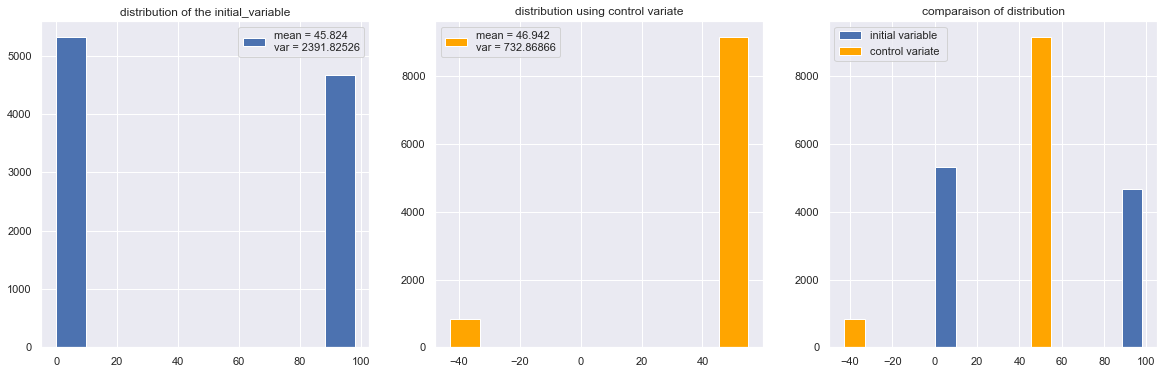

In [ ]:
plot_simulation(y, Y_control, bins = [10,10, 10, 10])

The variance of this method is very high because G = 100 and var(GZ) = G^2 * var(Z)

# Arithmetic asian option

### 1. Data generation

In [6]:
Z = np.random.randn(nb_samples, N_Local * Neuler_Local)
f_Asian_Local = lambda x: f_Asian_Arithmetic(x, K=K, L=L_Local, model='Local', Neuler=Neuler_Local, r=r, S0=S0, T=T, weight=weight_Local)
y = f_Asian_Local(Z)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

### 2. Model Creation

In [7]:
nnmodel_Asian_Local = DNN(N_Local * Neuler_Local, n=3)

In [8]:
nnmodel_Asian_Local.fit(X_train, y_train, eval_set=(X_test,y_test), verbose = True, patience = 30)

# Save the model
filename = 'Asian_Local.sav'
pickle.dump(nnmodel_Asian_Local, open(filename, 'wb'))

Epoch 1/1000
2500/2500 [==============================] - 7s 2ms/step - loss: 11.2301 - mse: 11.2301 - val_loss: 4.5171 - val_mse: 4.5171
Epoch 2/1000
2500/2500 [==============================] - 9s 4ms/step - loss: 6.2251 - mse: 6.2251 - val_loss: 6.4170 - val_mse: 6.4170
Epoch 3/1000
2500/2500 [==============================] - 7s 3ms/step - loss: 5.3378 - mse: 5.3378 - val_loss: 5.7614 - val_mse: 5.7614
Epoch 4/1000
2500/2500 [==============================] - 13s 5ms/step - loss: 4.5196 - mse: 4.5196 - val_loss: 3.5707 - val_mse: 3.5707
Epoch 5/1000
2500/2500 [==============================] - 8s 3ms/step - loss: 4.5703 - mse: 4.5703 - val_loss: 5.8492 - val_mse: 5.8492
Epoch 6/1000
2500/2500 [==============================] - 9s 4ms/step - loss: 3.8035 - mse: 3.8035 - val_loss: 3.3743 - val_mse: 3.3743
Epoch 7/1000
2500/2500 [==============================] - 6s 3ms/step - loss: 4.0183 - mse: 4.0183 - val_loss: 3.7685 - val_mse: 3.7685
Epoch 8/1000
2500/2500 [=====================

### 3. Test  and evaluation of the model

In [9]:
Z = np.random.randn(M_simulation, N_Local * Neuler_Local)
y = f_Asian_Local(Z)
y_pred = nnmodel_Asian_Local.model.predict(Z)
print('Monte Carlo price = {:.4}. Control variate price = {:.4}'.format(np.mean(y), np.mean(y_pred)))
mean_squared_error(y, y_pred)

313/313 [==============================] - 0s 724us/step
Monte Carlo price = 3.524. Control variate price = 3.388


3.8675293759700655

### 4. Simulation

True


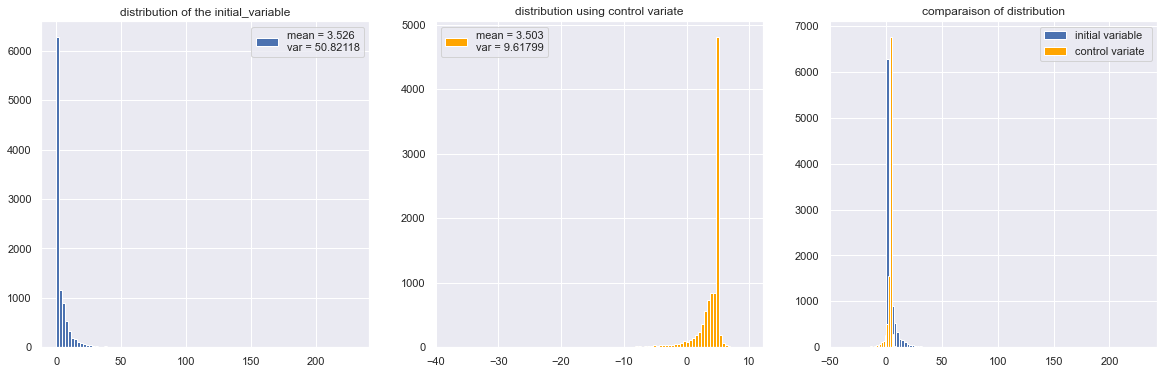

In [18]:
W = nnmodel_Asian_Local.model.get_weights()[0].T
print(matrix_rank(W)==len(W)) # we check that our matrix has maximal rank
y, Y_control = simulation(W, f_Asian_Local, N_Local * Neuler_Local)
plot_simulation(y, Y_control, [100, 100, 100, 30])


### 5. Robustness

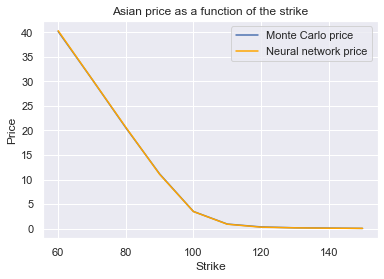

In [11]:
k_list = np.linspace(0.6, 1.5, 10)
y_MC = np.zeros(len(k_list))
y_CV = np.zeros(len(k_list))
for i, k in enumerate(k_list):
    f = lambda x : f_Asian_Arithmetic(x, K=k*K, L=L_Local, model='Local', Neuler=Neuler_Local, r=r, S0=S0, T=T, weight=weight_Local)
    y_MC[i], y_CV[i] = simulation_robust(W, f, N_Local * Neuler_Local)
plt.title('Asian price as a function of the strike')
plt.plot(k_list * K, y_MC, label = "Monte Carlo price")
plt.plot(k_list * K, y_CV, color='orange', label = "Neural network price")
plt.xlabel('Strike')
plt.ylabel('Price')
plt.legend()
plt.show()

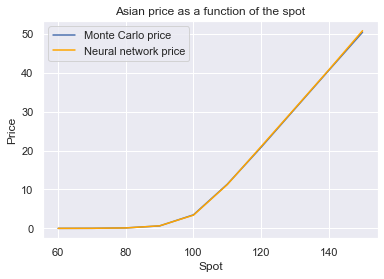

In [12]:
k_list = np.linspace(0.6, 1.5, 10)
y_MC = np.zeros(len(k_list))
y_CV = np.zeros(len(k_list))
for i, k in enumerate(k_list):
    f = lambda x : f_Asian_Arithmetic(x, K=K, L=L_Local, model='Local', Neuler=Neuler_Local, r=r, S0=k*S0, T=T, weight=weight_Local)
    y_MC[i], y_CV[i] = simulation_robust(W, f, N_Local * Neuler_Local)
plt.title('Asian price as a function of the spot')
plt.plot(k_list * S0, y_MC, label = "Monte Carlo price")
plt.plot(k_list * S0, y_CV, color='orange', label = "Neural network price")
plt.xlabel('Spot')
plt.ylabel('Price')
plt.legend()
plt.show()

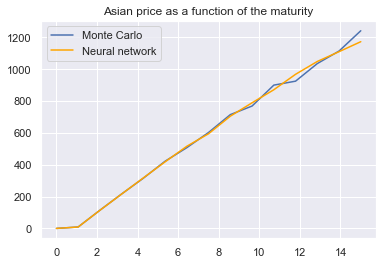

In [13]:
k_list = np.linspace(0, 15, 15)
y_MC = np.zeros(len(k_list))
y_CV = np.zeros(len(k_list))
for i, k in enumerate(k_list):
    f = lambda x : f_Asian_Arithmetic(x, K=K, L=L_Local, model='Local', Neuler=Neuler_Local, r=r, S0=k*S0, T=k*T, weight=weight_Local)
    y_MC[i], y_CV[i] = simulation_robust(W, f, N_Local * Neuler_Local)
plt.title('Asian price as a function of the maturity')
plt.plot(k_list * T, y_MC, label = "Monte Carlo")
plt.plot(k_list * T, y_CV, color='orange', label = "Neural network")
plt.legend()
plt.show()